In [19]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from IPython.display import display, HTML

#HTML(df.to_html())
#display(df)

hpi_red = '#b00639'
hpi_blue = '#007a9e'

def get_column_names(benchmark): 
    table_info = json.load(open(benchmark + '_results.csv.json','r'))
    #print(json.dumps(table_info, indent=2, sort_keys=False))
    column_names = []
    for column in table_info["columns"]:
        column_names.append(column["name"])
    return column_names

def get_results(benchmark):
    return pd.read_csv(benchmark + '_results.csv', header=None, names=get_column_names(benchmark))

def percent(x, pos):
    'The two args are the value and tick position'
    return ('%i' % (x * 100)) + "%"

# Columns: sample_size, distinct_values, variance, remainder_size, value, actual_count, filter_count
def select(data, value_count, distinct_values, data_distribution, quotient_size, remainder_size):
    return data[(data.value_count == value_count) &
                (data.distinct_values == distinct_values) &
                (data.data == data_distribution) & 
                (data.remainder_size == remainder_size) &
                (data.quotient_size == quotient_size)]

def get_mean_squared_error(errors, probabilities):
    mse = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        mse += probability * error * error
        
    return mse

def get_mean_error(errors, probabilities):
    me = 0.0
    for i in range(0, len(errors)):
        error = errors.iloc[i]
        probability = probabilities.iloc[i]
        me += probability * error
        
    return me

def misestimation_evaluation(quotient_size, remainder_size, data_distribution):
    #percent_formatter = FuncFormatter(percent)
    #ax.yaxis.set_major_formatter(percent_formatter)
    
    #Prepare the data
    data = get_results("cardinality_misestimation_" + data_distribution)
    distinct_values = data["distinct_values"].iloc[0]
    value_count = data["value_count"].iloc[0]
    selection = select(data, value_count, distinct_values, data_distribution, quotient_size, remainder_size)
    if len(selection) == 0:
        return
    sample_size = selection["sample_size"].iloc[0]
    over_estimations = selection["over_estimation"]
    probabilities = selection["occurrences"].apply(lambda x: x / sample_size)
    x_data = range(0, distinct_values)
    y_data = np.zeros(distinct_values)
    for i in range(0, len(over_estimations)):
        y_data[over_estimations.iloc[i]] = probabilities.iloc[i]
    one_off_probability = y_data[1]
    correct_probability = y_data[0]
    mean_error = get_mean_error(over_estimations, probabilities)
    mean_square_error = get_mean_squared_error(over_estimations, probabilities)
    filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
    filter_size_bytes = filter_size_bits / 8
    bits_per_value = filter_size_bits / value_count
    column_size = value_count * 2
    
    # Print some Information
    print("Sample Size: " + str(sample_size))
    print("One off error probability: " + str(one_off_probability))
    print("Mean Error: " + str(mean_error))
    print("Mean Squared Error: " + str(mean_square_error))
    print("Correct " + str(correct_probability * 100) + "%" + " of the time")
    print("Filter Size [kB]: " + str(filter_size_bytes / 1000))
    print("Bits per Value: " + str(bits_per_value))
    print("Column Size [kB](uint16_t): "  + str(column_size / 1000))
    
    # Configure the plot
    title = "Overcount probabilites"
    subtitle = "Value Count: " + str(value_count) \
                + ", Distinct Values: " + str(distinct_values) + ", Data: " + data_distribution + '\n'\
                + "Quotient Size: " + str(quotient_size) + ", Remainder Size: " + str(remainder_size)
    fig, ax = plt.subplots()
    plt.title(title + '\n' + subtitle)
    #.apply(lambda x: x * 100)
    plt.plot(x_data[1:100], np.array(y_data[1:100]) * 100, color=hpi_red, label="filter counts")
    plt.ylabel('probability [%]')
    plt.xlabel('overcount')
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)
    ax.yaxis.grid()
    ax.xaxis.grid()
    
    # Save Output
    file_name = (title + '_' + subtitle).replace(" ", "_").replace(":", "_").replace(".","_") \
                                        .replace(",","_").replace("\n","_")
    plt.savefig('plots/cardinality_estimation/{}.pgf'.format(file_name))
    plt.savefig('plots/cardinality_estimation/{}.pdf'.format(file_name))
    
    #Render
    plt.show()

def evaluate(quotient_size, remainder_size, data_distribution):
    data = get_results("filter_cardinality_estimation_" + data_distribution)
    distinct_values = data["distinct_values"].iloc[0]
    value_count = data["value_count"].iloc[0]
    selection = select(data, value_count, distinct_values, data_distribution, quotient_size, remainder_size)
    if len(selection) == 0:
        return
    
    title = "Filter Counts Vs. Actual Counts"
    subtitle = "Value Count: " + str(value_count) \
                + ", Distinct Values: " + str(distinct_values) + ", Data: " + data_distribution + '\n' \
                + "Quotient Size: " + str(quotient_size) + ", Remainder Size: " + str(remainder_size)
            
    fig, ax = plt.subplots()
    plt.title(title + '\n' + subtitle)
    plt.plot(selection["value"], selection["filter_count"], color=hpi_red, label="filter counts")
    plt.plot(selection["value"], selection["actual_count"], color=hpi_blue, label="actual counts")
    plt.legend(loc='upper left')
    plt.ylabel('value count')
    plt.xlabel('value')
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)
    ax.set_xlim(xmax=distinct_values)
    
    file_name = (title + '_' + subtitle).replace(" ", "_").replace(":", "_").replace(".","_").replace(",","_").replace("\n","_")
    plt.savefig('plots/cardinality_estimation/{}.pgf'.format(file_name))
    plt.savefig('plots/cardinality_estimation/{}.pdf'.format(file_name))
    plt.show()
    
def filter_comparison_table(quotient_sizes, remainder_sizes, data_distribution):
    data = get_results("cardinality_misestimation_" + data_distribution)
    distinct_values = data["distinct_values"].iloc[0]
    value_count = data["value_count"].iloc[0]
    
    filter_information = []
    
    for quotient_size in quotient_sizes:
        for remainder_size in remainder_sizes:
                selection = select(data, value_count, distinct_values, data_distribution, quotient_size, remainder_size)
                if len(selection) == 0:
                    continue
                sample_size = selection["sample_size"].iloc[0]
                x_data = selection["over_estimation"]
                y_data = selection["occurrences"].apply(lambda x: x / sample_size)
                filter_size_bits = pow(2, quotient_size) * (2 + remainder_size)
                filter_size_bytes = filter_size_bits / 8
                bits_per_value = filter_size_bits / value_count
                mean_error = get_mean_error(x_data, y_data)
                mean_squared_error = get_mean_squared_error(x_data, y_data)
                correct_probability = y_data.iloc[0]
                filter_information.append((quotient_size, remainder_size, bits_per_value, mean_error, mean_squared_error))
    

    columns = ["Quotient Size", "Remainder Size", "Bits per Value", "Mean Error", "Mean Squared Error"]
    df = pd.DataFrame(filter_information, columns=columns)
    #display(df.sort_values(by=["Bits per Value"]))
    display(df)
    

In [32]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14, 15, 16, 17]
filter_comparison_table(quotient_sizes, remainder_sizes, "normal50000")

,Quotient Size,Remainder Size,Bits per Value,Mean Error,Mean Squared Error
0,14,4,0.98304,0.373717,21.223029
1,14,8,1.63840,0.023328,1.311848
2,14,16,2.94912,0.000070,0.004259
3,15,2,1.31072,0.747980,42.771320
4,15,4,1.96608,0.187328,10.599532
5,15,8,3.27680,0.011627,0.651440
6,15,16,5.89824,0.000055,0.003481
7,16,2,2.62144,0.374424,21.235435
8,16,4,3.93216,0.093097,5.267351
9,16,8,6.55360,0.005796,0.322289


In [20]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14, 15, 16, 17]
filter_comparison_table(quotient_sizes, remainder_sizes, "uniform3000")

,Quotient Size,Remainder Size,Bits per Value,Mean Error,Mean Squared Error
0,14,4,0.98304,0.378242,12.633562
1,14,8,1.63840,0.024959,0.823647
2,14,16,2.94912,0.000081,0.002686
3,15,2,1.31072,0.754041,25.440492
4,15,4,1.96608,0.187794,6.261024
5,15,8,3.27680,0.012340,0.407213
6,15,16,5.89824,0.000103,0.003412
7,16,2,2.62144,0.376770,12.581943
8,16,4,3.93216,0.095201,3.148807
9,16,8,6.55360,0.006079,0.200594


Sample Size: 30000000
One off error probability: 0.0009427
Mean Error: 0.371409733333
Mean Squared Error: 21.0695643333
Correct 98.8802466667% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


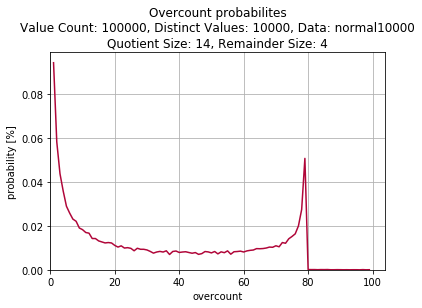

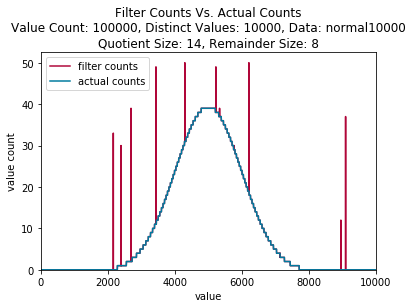

Sample Size: 30000000
One off error probability: 6.04666666667e-05
Mean Error: 0.0238732333333
Mean Squared Error: 1.33397456667
Correct 99.92742% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


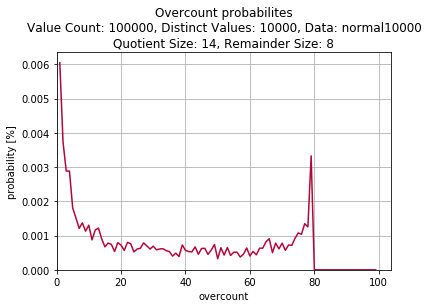

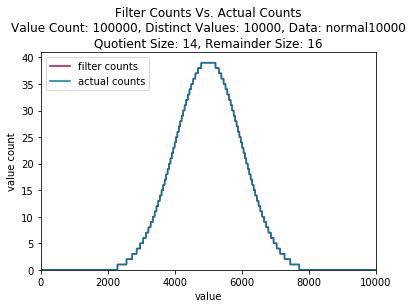

Sample Size: 30000000
One off error probability: 6.66666666667e-07
Mean Error: 9.74333333333e-05
Mean Squared Error: 0.0042397
Correct 99.99963% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


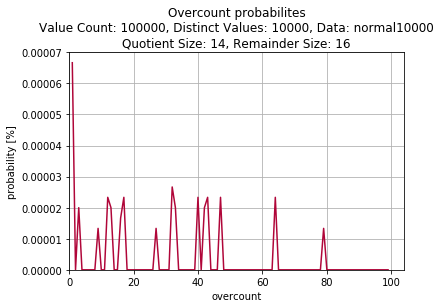

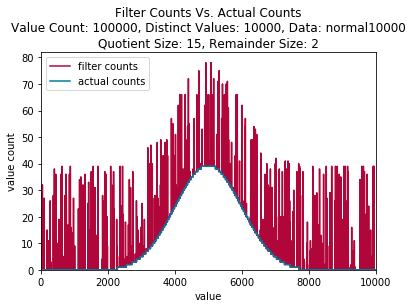

Sample Size: 30000000
One off error probability: 0.00182566666667
Mean Error: 0.7455945
Mean Squared Error: 42.5353465667
Correct 97.7690566667% of the time
Filter Size [kB]: 16.384
Bits per Value: 1.31072
Column Size [kB](uint16_t): 200.0


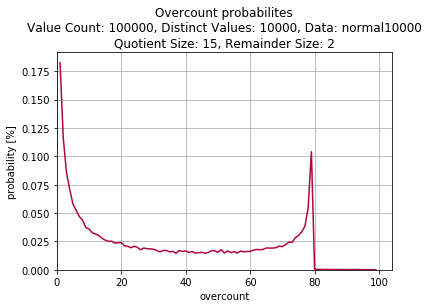

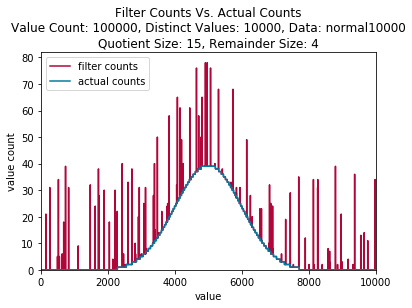

Sample Size: 30000000
One off error probability: 0.000476433333333
Mean Error: 0.186251666667
Mean Squared Error: 10.5360069333
Correct 99.43921% of the time
Filter Size [kB]: 24.576
Bits per Value: 1.96608
Column Size [kB](uint16_t): 200.0


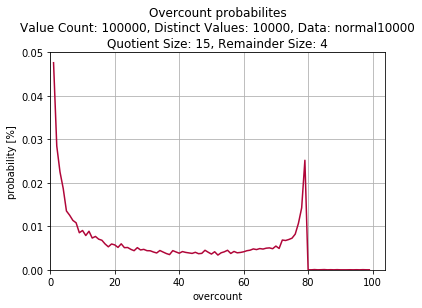

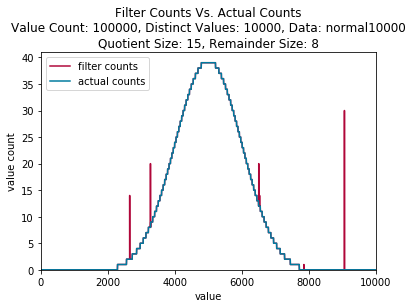

Sample Size: 30000000
One off error probability: 2.96e-05
Mean Error: 0.0121473333333
Mean Squared Error: 0.674800133333
Correct 99.9629666667% of the time
Filter Size [kB]: 40.96
Bits per Value: 3.2768
Column Size [kB](uint16_t): 200.0


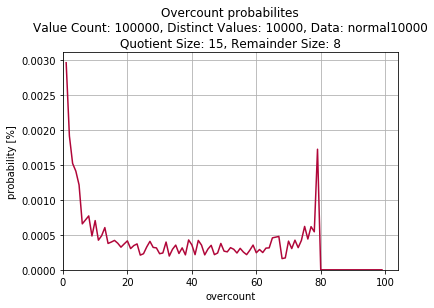

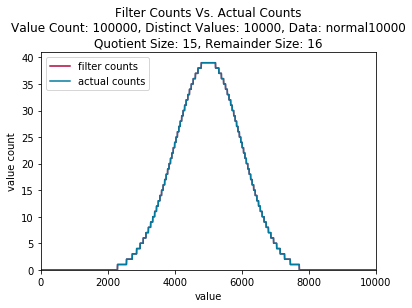

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 2.69333333333e-05
Mean Squared Error: 0.000867933333333
Correct 99.9999% of the time
Filter Size [kB]: 73.728
Bits per Value: 5.89824
Column Size [kB](uint16_t): 200.0


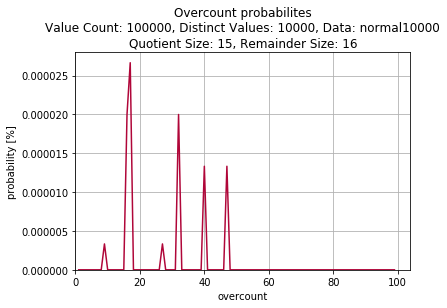

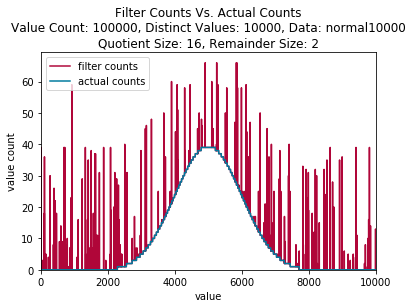

Sample Size: 30000000
One off error probability: 0.0009404
Mean Error: 0.3713375
Mean Squared Error: 21.0863802333
Correct 98.88363% of the time
Filter Size [kB]: 32.768
Bits per Value: 2.62144
Column Size [kB](uint16_t): 200.0


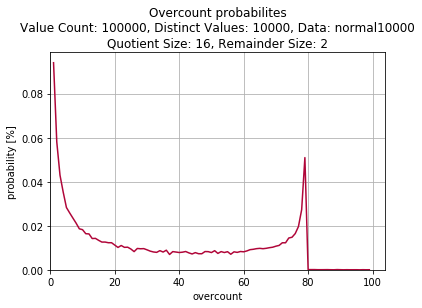

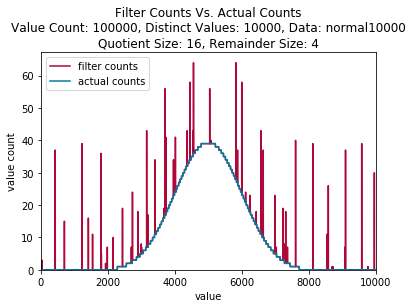

Sample Size: 30000000
One off error probability: 0.0002374
Mean Error: 0.0920365333333
Mean Squared Error: 5.16444186667
Correct 99.72033% of the time
Filter Size [kB]: 49.152
Bits per Value: 3.93216
Column Size [kB](uint16_t): 200.0


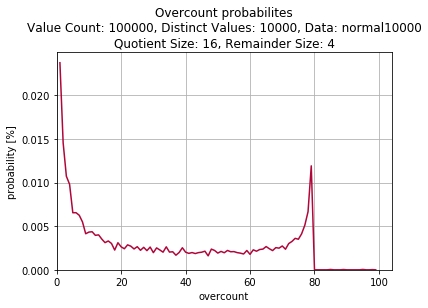

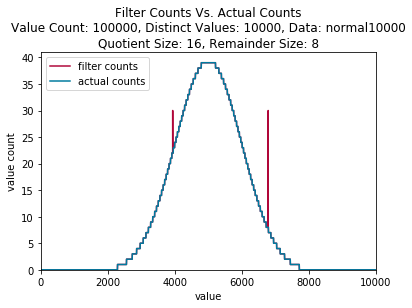

Sample Size: 30000000
One off error probability: 1.66333333333e-05
Mean Error: 0.00630643333333
Mean Squared Error: 0.3517661
Correct 99.9809066667% of the time
Filter Size [kB]: 81.92
Bits per Value: 6.5536
Column Size [kB](uint16_t): 200.0


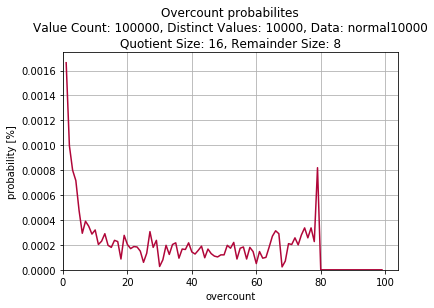

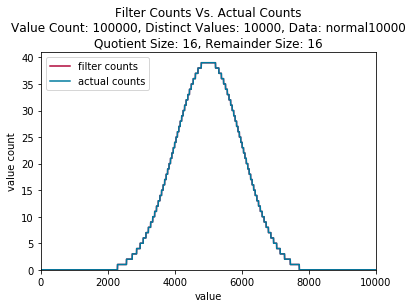

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 4.26666666667e-06
Mean Squared Error: 0.000136533333333
Correct 99.9999866667% of the time
Filter Size [kB]: 147.456
Bits per Value: 11.79648
Column Size [kB](uint16_t): 200.0


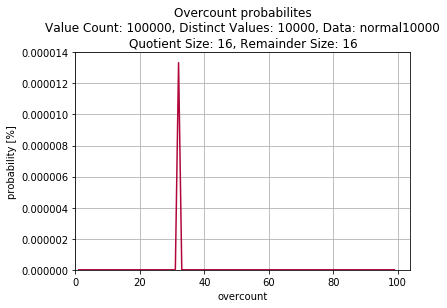

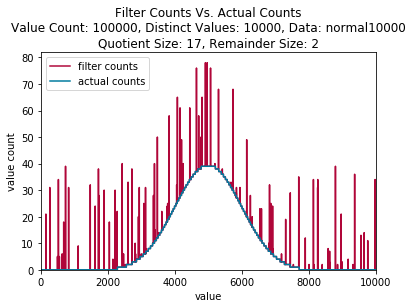

Sample Size: 30000000
One off error probability: 0.000474733333333
Mean Error: 0.1870138
Mean Squared Error: 10.5626177333
Correct 99.4363333333% of the time
Filter Size [kB]: 65.536
Bits per Value: 5.24288
Column Size [kB](uint16_t): 200.0


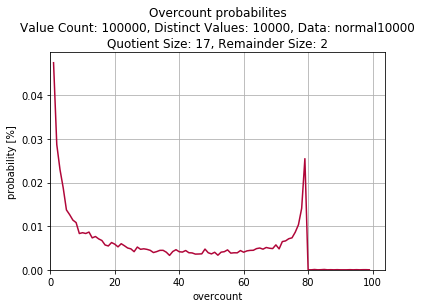

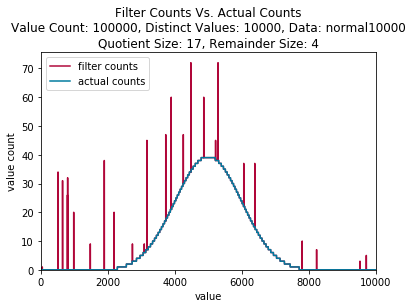

Sample Size: 30000000
One off error probability: 0.0001189
Mean Error: 0.0470981333333
Mean Squared Error: 2.64123773333
Correct 99.8570033333% of the time
Filter Size [kB]: 98.304
Bits per Value: 7.86432
Column Size [kB](uint16_t): 200.0


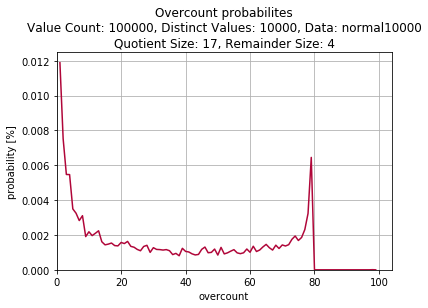

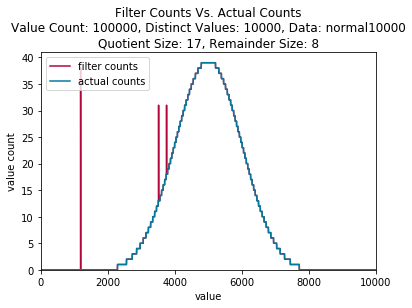

Sample Size: 30000000
One off error probability: 7.86666666667e-06
Mean Error: 0.00290823333333
Mean Squared Error: 0.159811566667
Correct 99.9909166667% of the time
Filter Size [kB]: 163.84
Bits per Value: 13.1072
Column Size [kB](uint16_t): 200.0


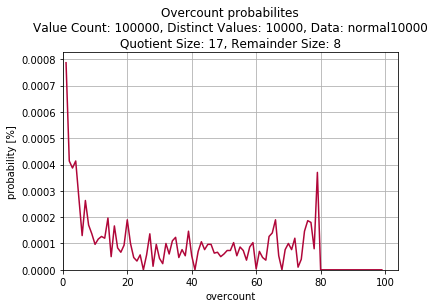

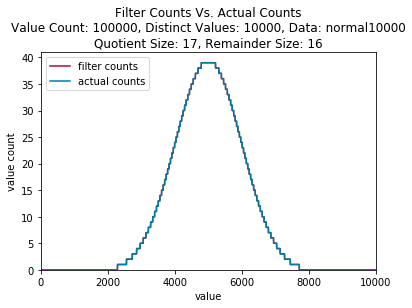

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 5.33333333333e-06
Mean Squared Error: 0.000170666666667
Correct 99.9999833333% of the time
Filter Size [kB]: 294.912
Bits per Value: 23.59296
Column Size [kB](uint16_t): 200.0


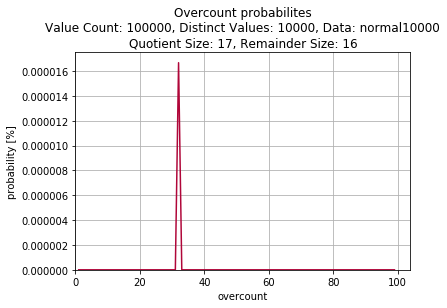

In [28]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [12, 13, 14, 15, 16, 17]

for quotient_size in quotient_sizes:
    for remainder_size in remainder_sizes:
        evaluate(quotient_size, remainder_size, "normal10000")
        misestimation_evaluation(quotient_size, remainder_size, "normal10000")

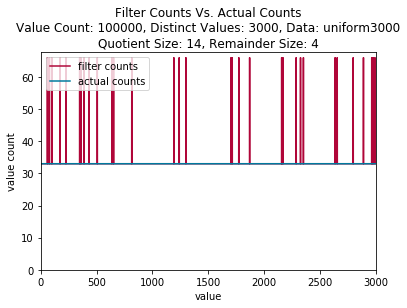

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.3782416
Mean Squared Error: 12.6335616
Correct 98.8607733333% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


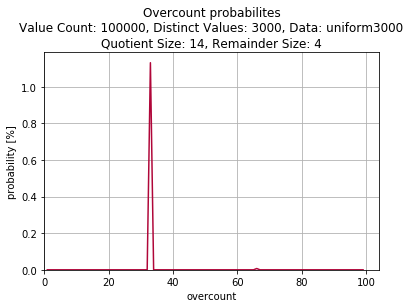

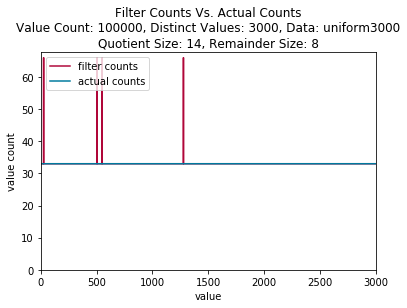

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.024959
Mean Squared Error: 0.823647
Correct 99.9243666667% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


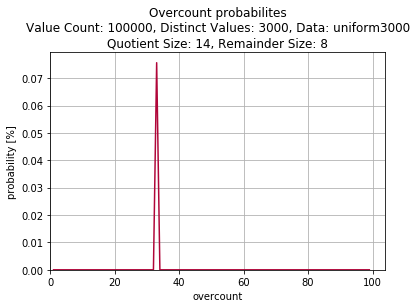

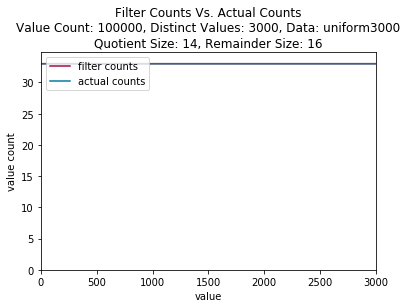

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 8.14e-05
Mean Squared Error: 0.0026862
Correct 99.9997533333% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


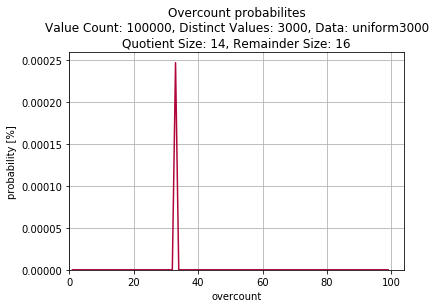

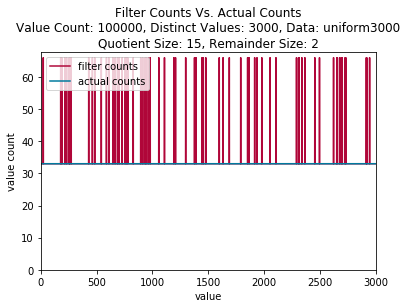

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.7540412
Mean Squared Error: 25.440492
Correct 97.7406066667% of the time
Filter Size [kB]: 16.384
Bits per Value: 1.31072
Column Size [kB](uint16_t): 200.0


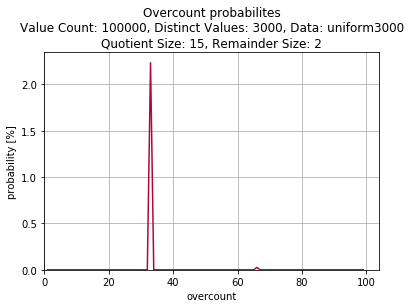

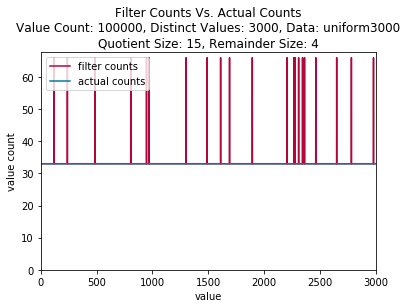

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.1877942
Mean Squared Error: 6.261024
Correct 99.4338566667% of the time
Filter Size [kB]: 24.576
Bits per Value: 1.96608
Column Size [kB](uint16_t): 200.0


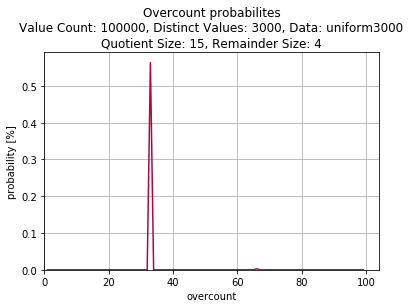

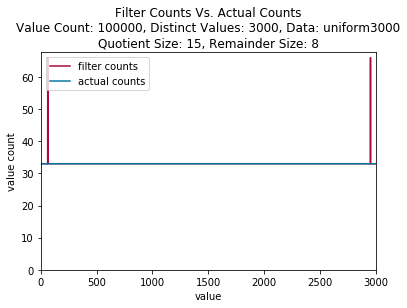

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0123398
Mean Squared Error: 0.4072134
Correct 99.9626066667% of the time
Filter Size [kB]: 40.96
Bits per Value: 3.2768
Column Size [kB](uint16_t): 200.0


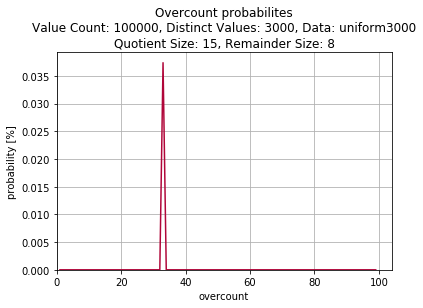

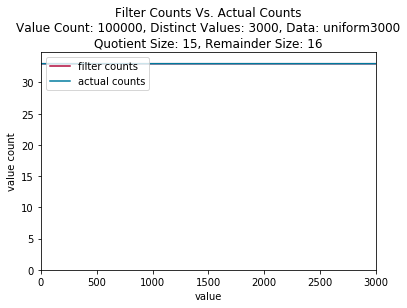

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0001034
Mean Squared Error: 0.0034122
Correct 99.9996866667% of the time
Filter Size [kB]: 73.728
Bits per Value: 5.89824
Column Size [kB](uint16_t): 200.0


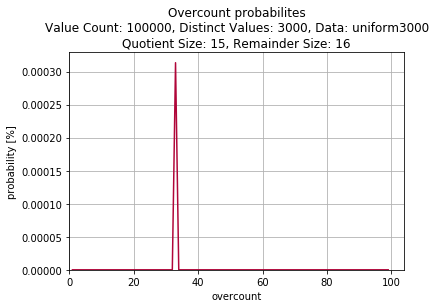

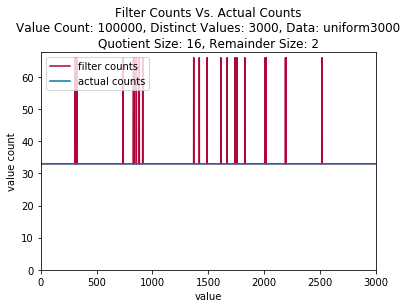

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.3767698
Mean Squared Error: 12.581943
Correct 98.8650933333% of the time
Filter Size [kB]: 32.768
Bits per Value: 2.62144
Column Size [kB](uint16_t): 200.0


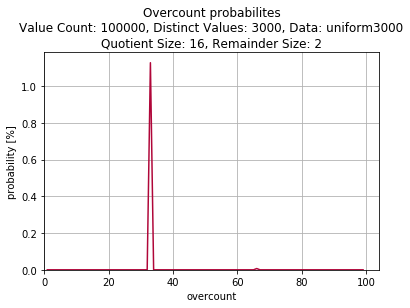

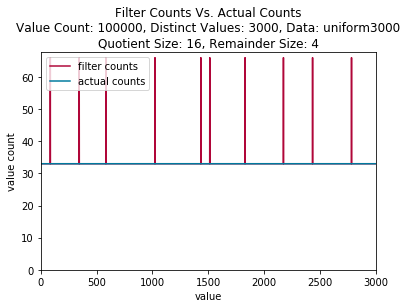

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0952006
Mean Squared Error: 3.1488072
Correct 99.7118433333% of the time
Filter Size [kB]: 49.152
Bits per Value: 3.93216
Column Size [kB](uint16_t): 200.0


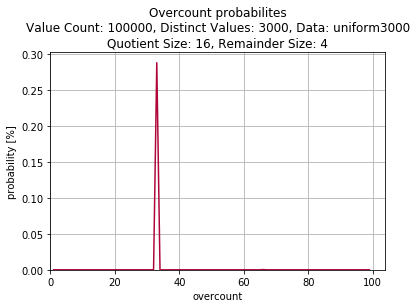

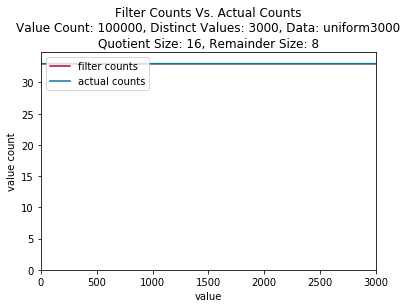

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0060786
Mean Squared Error: 0.2005938
Correct 99.98158% of the time
Filter Size [kB]: 81.92
Bits per Value: 6.5536
Column Size [kB](uint16_t): 200.0


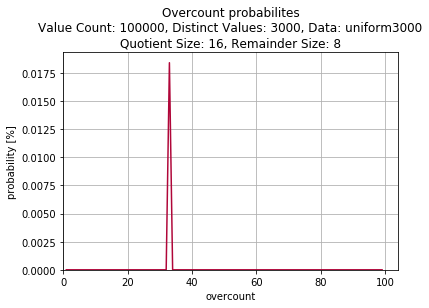

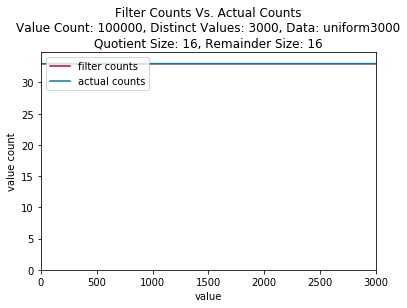

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 8.8e-05
Mean Squared Error: 0.002904
Correct 99.9997333333% of the time
Filter Size [kB]: 147.456
Bits per Value: 11.79648
Column Size [kB](uint16_t): 200.0


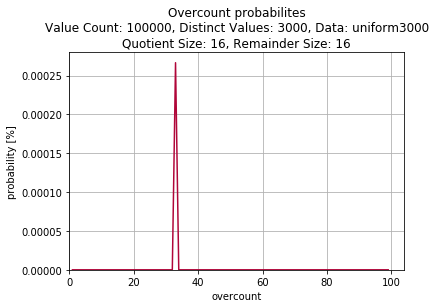

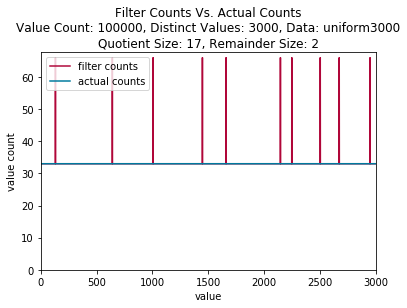

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.1879746
Mean Squared Error: 6.2630568
Correct 99.43313% of the time
Filter Size [kB]: 65.536
Bits per Value: 5.24288
Column Size [kB](uint16_t): 200.0


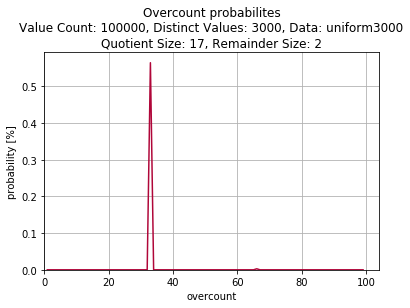

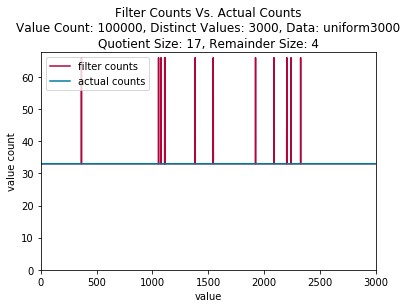

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0502216
Mean Squared Error: 1.6605798
Correct 99.8479633333% of the time
Filter Size [kB]: 98.304
Bits per Value: 7.86432
Column Size [kB](uint16_t): 200.0


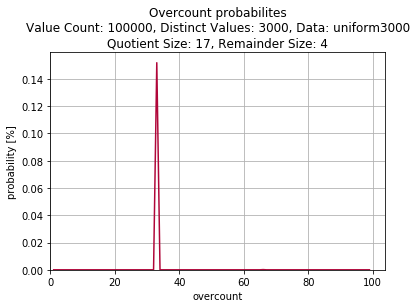

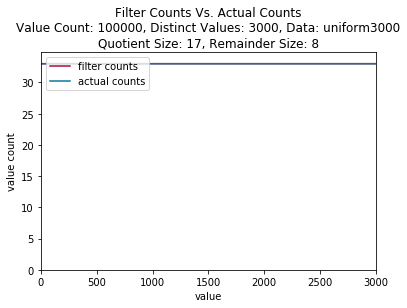

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0030074
Mean Squared Error: 0.0992442
Correct 99.9908866667% of the time
Filter Size [kB]: 163.84
Bits per Value: 13.1072
Column Size [kB](uint16_t): 200.0


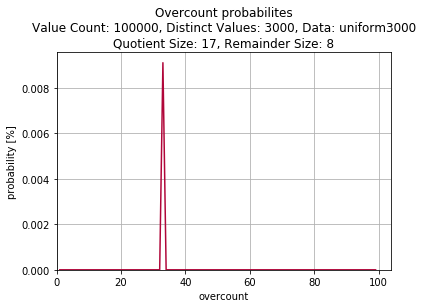

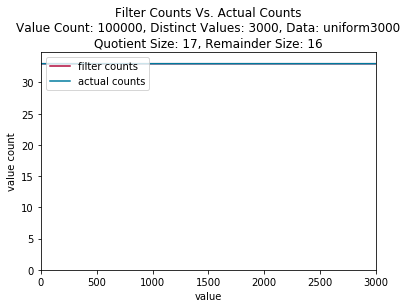

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 8.58e-05
Mean Squared Error: 0.0028314
Correct 99.99974% of the time
Filter Size [kB]: 294.912
Bits per Value: 23.59296
Column Size [kB](uint16_t): 200.0


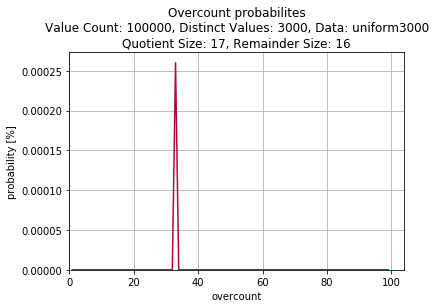

In [29]:
remainder_sizes = [2, 4, 8, 16]
quotient_sizes = [14, 15, 16, 17]

for quotient_size in quotient_sizes:
    for remainder_size in remainder_sizes:
        evaluate(quotient_size, remainder_size, "uniform3000")
        misestimation_evaluation(quotient_size, remainder_size, "uniform3000")

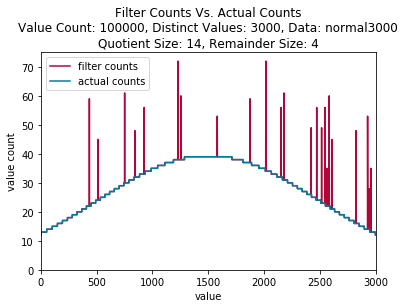

Sample Size: 30000000
One off error probability: 0.000900233333333
Mean Error: 0.376060766667
Mean Squared Error: 21.4024493
Correct 98.8826066667% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


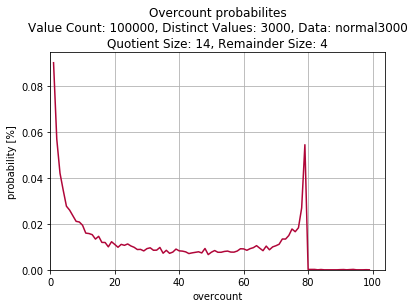

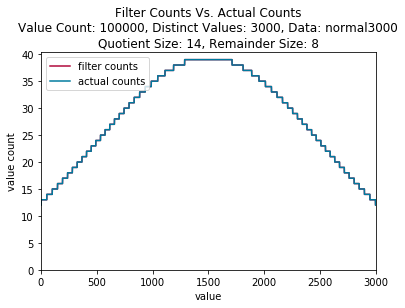

Sample Size: 30000000
One off error probability: 6.71666666667e-05
Mean Error: 0.0248788666667
Mean Squared Error: 1.41160573333
Correct 99.92434% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


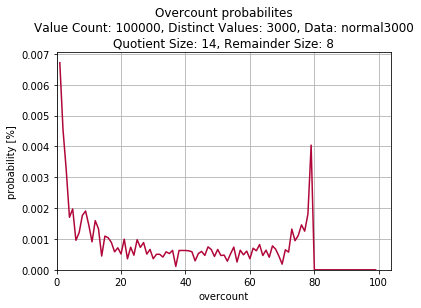

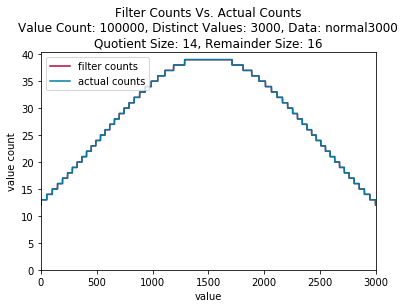

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.0001026
Mean Squared Error: 0.0045562
Correct 99.99966% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


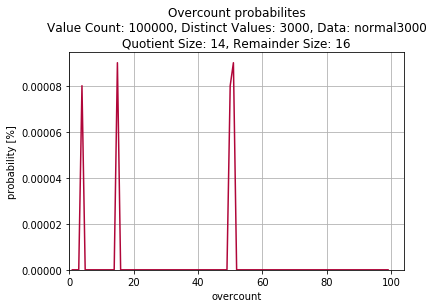

In [35]:
evaluate(14, 4, "normal3000")
misestimation_evaluation(14, 4, "normal3000")
evaluate(14, 8, "normal3000")
misestimation_evaluation(14, 8, "normal3000")
evaluate(14, 16, "normal3000")
misestimation_evaluation(14, 16, "normal3000")

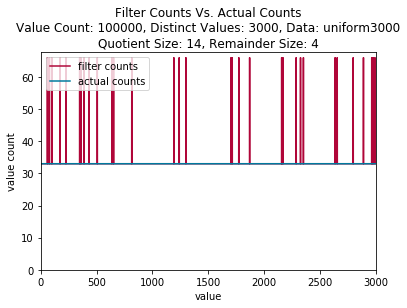

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.3782416
Mean Squared Error: 12.6335616
Correct 98.8607733333% of the time
Filter Size [kB]: 12.288
Bits per Value: 0.98304
Column Size [kB](uint16_t): 200.0


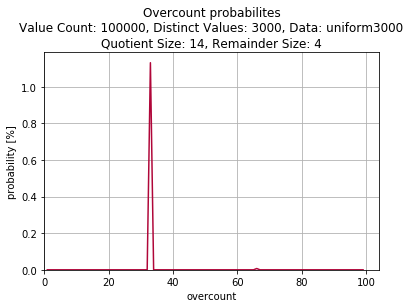

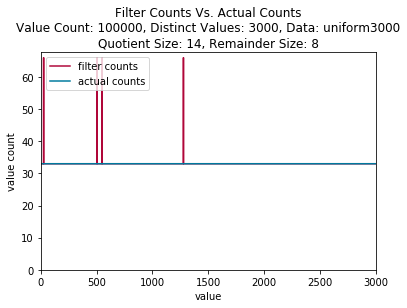

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 0.024959
Mean Squared Error: 0.823647
Correct 99.9243666667% of the time
Filter Size [kB]: 20.48
Bits per Value: 1.6384
Column Size [kB](uint16_t): 200.0


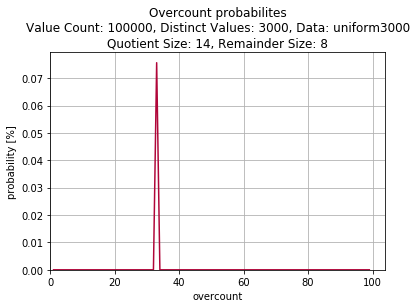

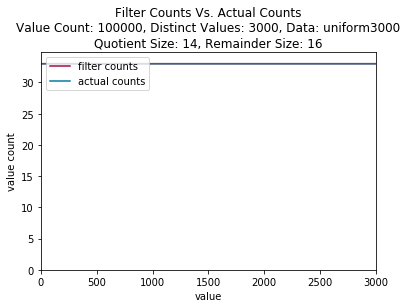

Sample Size: 30000000
One off error probability: 0.0
Mean Error: 8.14e-05
Mean Squared Error: 0.0026862
Correct 99.9997533333% of the time
Filter Size [kB]: 36.864
Bits per Value: 2.94912
Column Size [kB](uint16_t): 200.0


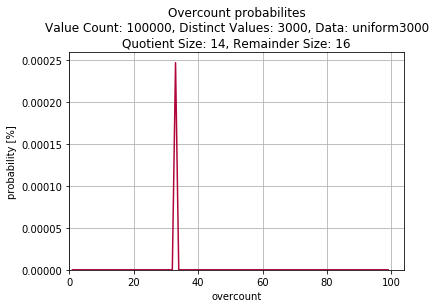

In [34]:
evaluate(14, 4, "uniform3000")
misestimation_evaluation(14, 4, "uniform3000")
evaluate(14, 8, "uniform3000")
misestimation_evaluation(14, 8, "uniform3000")
evaluate(14, 16, "uniform3000")
misestimation_evaluation(14, 16, "uniform3000")